In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# ============================================
# 1. LOAD CLEANED DATA
# ============================================

# Upload cleaned data
from google.colab import files
print("Upload google_stock_cleaned.csv file...")
uploaded = files.upload()

df = pd.read_csv('google_stock_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(f"Data loaded: {len(df)} rows")
print(df.head())

Upload google_stock_cleaned.csv file...


Saving google_stock_cleaned.csv to google_stock_cleaned.csv
Data loaded: 1258 rows
                       Date       Open       High        Low      Close  \
0 2020-01-02 00:00:00+00:00  67.420502  68.433998  67.324501  68.433998   
1 2020-01-03 00:00:00+00:00  67.400002  68.687500  67.365997  68.075996   
2 2020-01-06 00:00:00+00:00  67.581497  69.916000  67.550003  69.890503   
3 2020-01-07 00:00:00+00:00  70.023003  70.175003  69.578003  69.755501   
4 2020-01-08 00:00:00+00:00  69.740997  70.592499  69.631500  70.251999   

     Volume  
0  27278000  
1  23408000  
2  46768000  
3  34330000  
4  35314000  


In [ ]:
# ============================================
# 2. PREPARE DATA FOR LSTM
# ============================================

# Use Close price for prediction
data = df['Close'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Save scaler for later use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set sequence length (60 days)
SEQ_LENGTH = 60

X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data: 80% train, 20% test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Sequence length: {SEQ_LENGTH}")



Training samples: 958
Testing samples: 240
Sequence length: 60


In [ ]:
#============================================
# 3. BUILD LSTM MODEL
# ============================================

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
# ============================================
# 4. BUILD RNN MODEL (for comparison)
# ============================================

def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(64, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(32, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
# ============================================
# 5. BUILD GRU MODEL (for comparison)
# ============================================

def build_gru_model(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=True),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
# ============================================
# 6. TRAIN MODELS
# ============================================

input_shape = (X_train.shape[1], 1)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n" + "="*80)
print("TRAINING LSTM MODEL")
print("="*80)

lstm_model = build_lstm_model(input_shape)
print(lstm_model.summary())

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Save LSTM model
lstm_model.save('lstm_model.h5')
print("LSTM model saved!")

print("\n" + "="*80)
print("TRAINING RNN MODEL")
print("="*80)

rnn_model = build_rnn_model(input_shape)
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

rnn_model.save('rnn_model.h5')
print("RNN model saved!")

print("\n" + "="*80)
print("TRAINING GRU MODEL")
print("="*80)

gru_model = build_gru_model(input_shape)
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

gru_model.save('gru_model.h5')
print("GRU model saved!")


TRAINING LSTM MODEL


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,235 (504.82 KB)

 Trainable params: 129,235 (504.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 0.0383 - mae: 0.1437 - val_loss: 0.0082 - val_mae: 0.0853
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0041 - mae: 0.0506 - val_loss: 0.0011 - val_mae: 0.0272
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0030 - mae: 0.0425 - val_loss: 0.0012 - val_mae: 0.0283
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0031 - mae: 0.0426 - val_loss: 0.0020 - val_mae: 0.0401
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0027 - mae: 0.0397 - val_loss: 0.0012 - val_mae: 0.0289
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0027 - mae: 0.0401 - val_loss: 0.0017 - val_mae: 0.0361
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.0023 - mae: 0.0375 - val_loss: 0.0013 - val_mae: 0.0249
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0024 - mae: 0.0376 - val_loss: 0.0015 - val_mae: 0.0338
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/ste

LSTM model saved!

TRAINING RNN MODEL
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.9878 - mae: 0.7972 - val_loss: 0.0599 - val_mae: 0.2424
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4870 - mae: 0.5515 - val_loss: 0.0291 - val_mae: 0.1674
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2762 - mae: 0.4179 - val_loss: 0.0355 - val_mae: 0.1859
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1850 - mae: 0.3434 - val_loss: 0.0716 - val_mae: 0.2659
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1421 - mae: 0.3046 - val_loss: 0.0099 - val_mae: 0.0949
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0778 - mae: 0.2261 - val_loss: 8.3207e-04 - val_mae: 0.0222
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0529 - mae: 0.1807 - val_loss: 0.0052 - val_mae: 0.0662
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0289 - mae: 0.1356 - val_loss: 9.2698e-04 - val_mae: 0.0249
Epoch 9/50
27/27 ━

RNN model saved!

TRAINING GRU MODEL
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0347 - mae: 0.1409 - val_loss: 0.0064 - val_mae: 0.0761
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.0042 - mae: 0.0497 - val_loss: 8.9783e-04 - val_mae: 0.0251
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0034 - mae: 0.0430 - val_loss: 8.0667e-04 - val_mae: 0.0229
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0025 - mae: 0.0358 - val_loss: 8.9642e-04 - val_mae: 0.0203
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0022 - mae: 0.0359 - val_loss: 7.7836e-04 - val_mae: 0.0223
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0022 - mae: 0.0357 - val_loss: 7.6101e-04 - val_mae: 0.0220
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 0.0012 - val_mae: 0.0304
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 0.0019 - mae: 0.0323 - val_loss: 9.3906e-04 - val_mae: 0

GRU model saved!


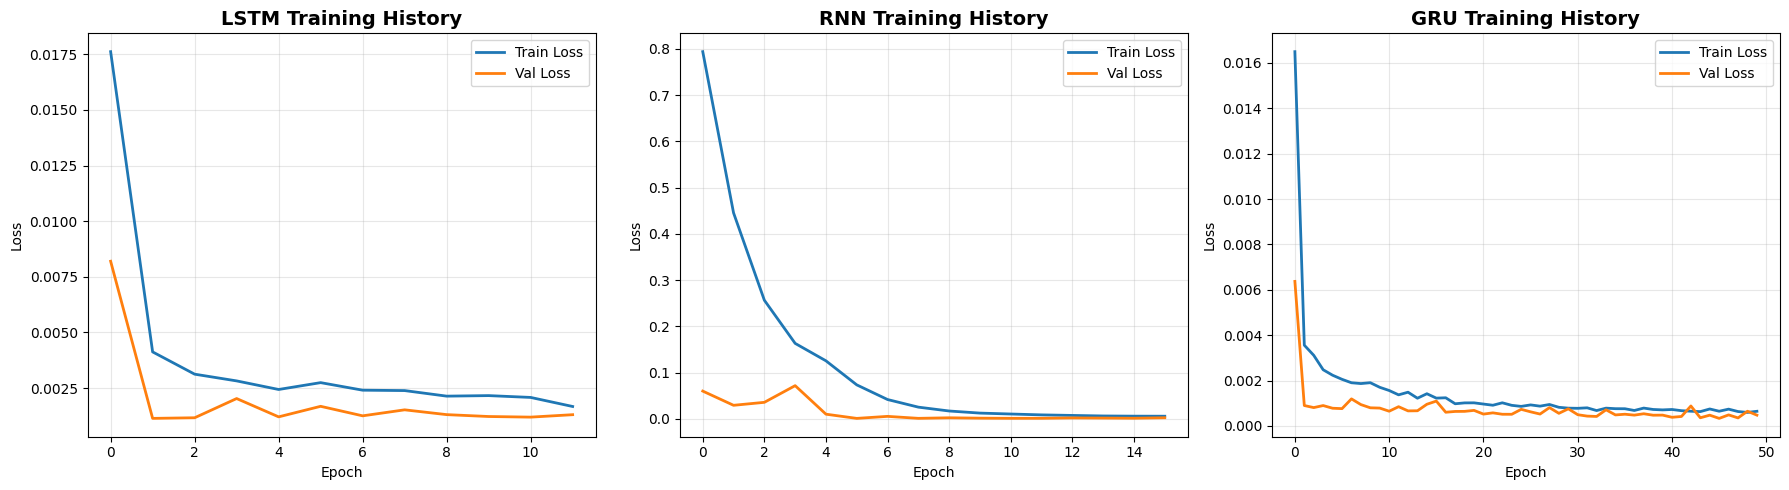

In [ ]:
# ============================================
# 7. PLOT TRAINING HISTORY
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LSTM
axes[0].plot(history_lstm.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_lstm.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('LSTM Training History', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RNN
axes[1].plot(history_rnn.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_rnn.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('RNN Training History', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# GRU
axes[2].plot(history_gru.history['loss'], label='Train Loss', linewidth=2)
axes[2].plot(history_gru.history['val_loss'], label='Val Loss', linewidth=2)
axes[2].set_title('GRU Training History', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# 8. EVALUATE MODELS
# ============================================

def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)

    # Inverse transform
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, predictions)
    r2 = r2_score(y_test_actual, predictions)
    mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

    print(f"\n{model_name} MODEL PERFORMANCE:")
    print("="*50)
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print("="*50)

    return predictions, y_test_actual

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

lstm_pred, y_actual = evaluate_model(lstm_model, X_test, y_test, "LSTM")
rnn_pred, _ = evaluate_model(rnn_model, X_test, y_test, "RNN")
gru_pred, _ = evaluate_model(gru_model, X_test, y_test, "GRU")



MODEL EVALUATION
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step

LSTM MODEL PERFORMANCE:
MSE:  76.2527
RMSE: 8.7323
MAE:  7.2538
R²:   0.6506
MAPE: 4.32%
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

RNN MODEL PERFORMANCE:
MSE:  707.0113
RMSE: 26.5897
MAE:  23.7220
R²:   -2.2400
MAPE: 13.83%


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step

GRU MODEL PERFORMANCE:
MSE:  11.4769
RMSE: 3.3878
MAE:  2.4381
R²:   0.9474
MAPE: 1.48%


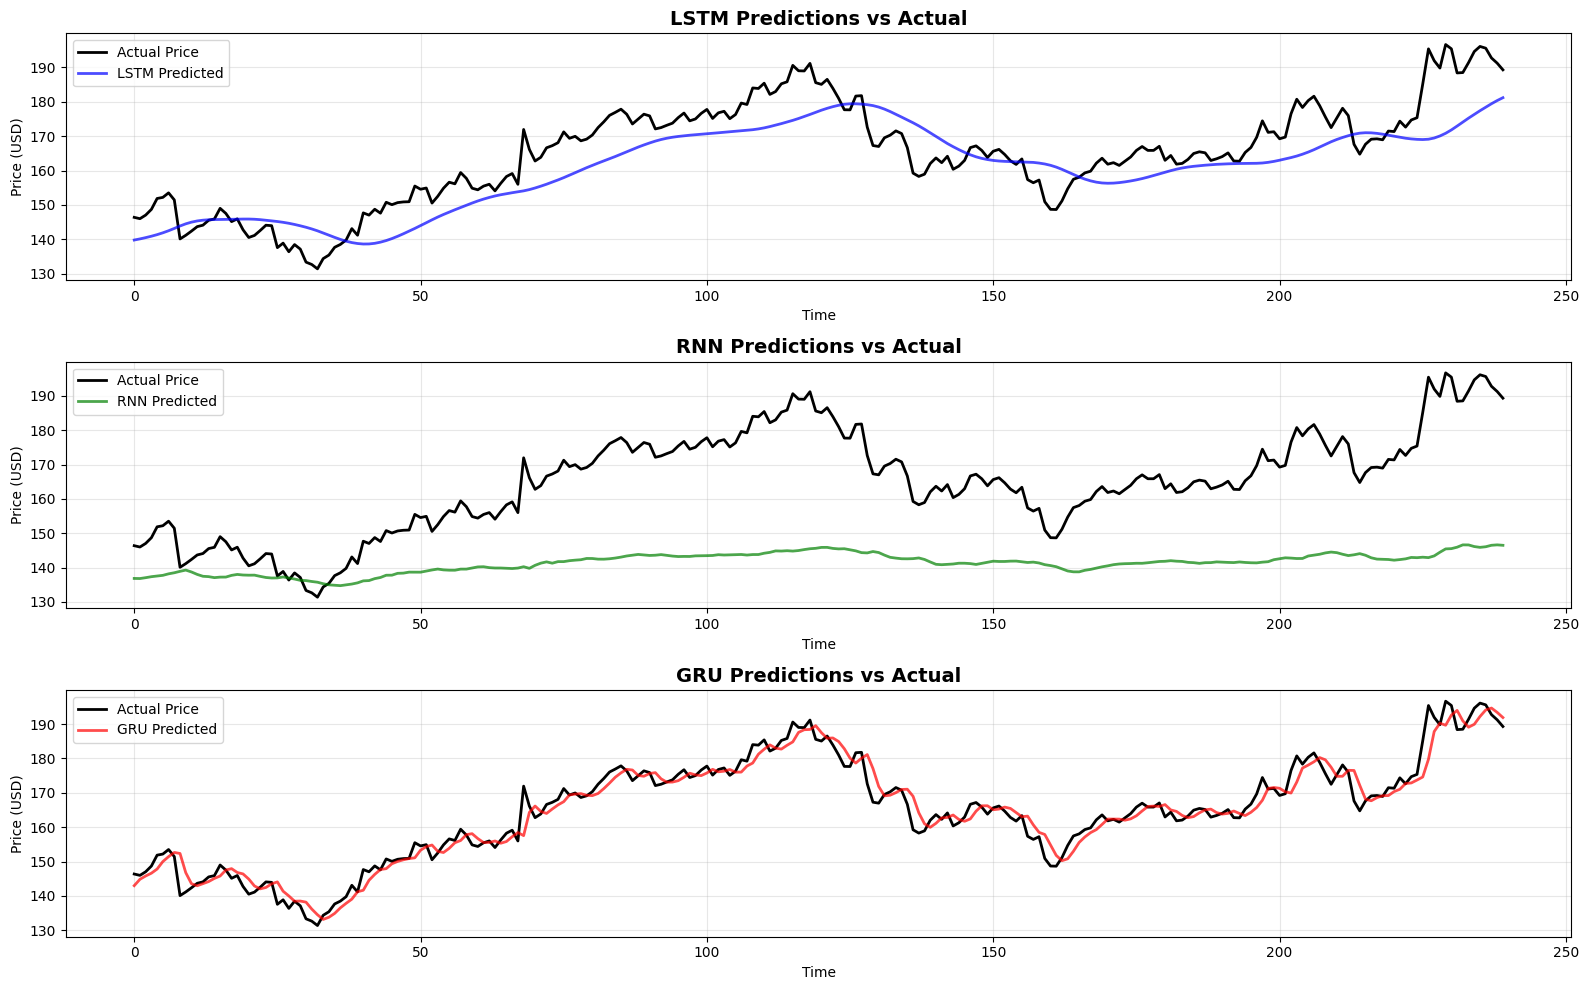

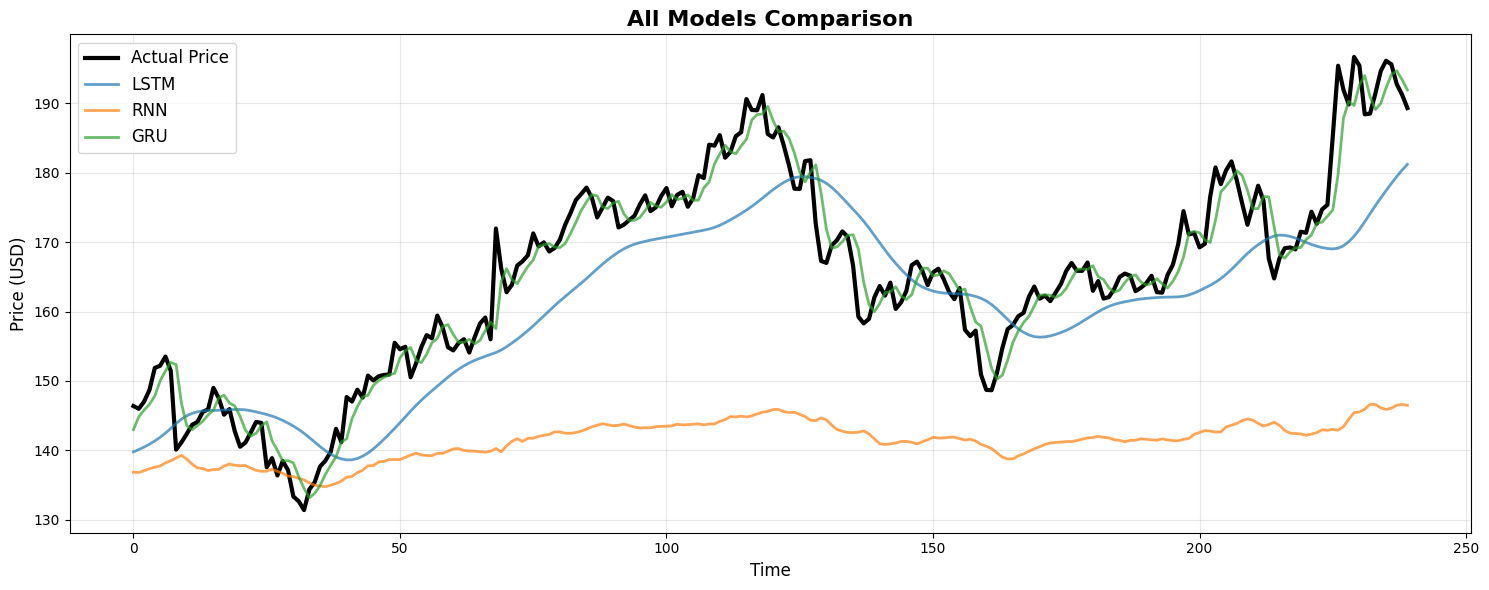

In [ ]:
# ============================================
# 9. VISUALIZE PREDICTIONS
# ============================================

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(y_actual, label='Actual Price', linewidth=2, color='black')
plt.plot(lstm_pred, label='LSTM Predicted', linewidth=2, color='blue', alpha=0.7)
plt.title('LSTM Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(y_actual, label='Actual Price', linewidth=2, color='black')
plt.plot(rnn_pred, label='RNN Predicted', linewidth=2, color='green', alpha=0.7)
plt.title('RNN Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(y_actual, label='Actual Price', linewidth=2, color='black')
plt.plot(gru_pred, label='GRU Predicted', linewidth=2, color='red', alpha=0.7)
plt.title('GRU Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison plot
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Actual Price', linewidth=3, color='black')
plt.plot(lstm_pred, label='LSTM', linewidth=2, alpha=0.7)
plt.plot(rnn_pred, label='RNN', linewidth=2, alpha=0.7)
plt.plot(gru_pred, label='GRU', linewidth=2, alpha=0.7)
plt.title('All Models Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# 10. DOWNLOAD FILES
# ============================================

print("\n" + "="*80)
print("DOWNLOADING MODEL FILES...")
print("="*80)

files.download('lstm_model.h5')
files.download('rnn_model.h5')
files.download('gru_model.h5')
files.download('scaler.pkl')

print("\n All files downloaded! You'll need these for the interface.")


DOWNLOADING MODEL FILES...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 All files downloaded! You'll need these for the interface.
